# Masking and pruning BERT heads
### By Pavlo Kravets

As my project for a Deep Learning course, I decided to recreate the famous experiment: removing the heads of fine-tuned BERT model and testing how much the performance will be impacted.

The original paper, "Are Sixteen Heads Really Better than One?" by Michel et al. can be found [here](https://arxiv.org/abs/1905.10650).

I used the Transformers library by Huggingface (basing it on PyTorch). A lot of this work is based on their [experimental setup](https://github.com/huggingface/transformers/blob/main/examples/research_projects/bertology/run_bertology.py). Sadly (or luckily, because I got to do something interesting), it does not seem to work with the current Transformers version, so I had to rework it a bit.

In [1]:
!pip install transformers[torch]
!pip install datasets
!pip install evaluate

# Dataset and model

I will be using bert-base-uncased as my model of choice and will perform the evaluation against CoLA task. Given that it is a benchmark task, and the test labels are unavailable, I had to create new dataset to use. I united the train and validation splits, and the split the result into three parts: train, validation, and test. As such, the obtained results cannot be directly compared to the benchmark, as a task is a bit different.

In [2]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    set_seed
)
from datasets import (
    load_dataset,
    DatasetDict
)
from functools import partial
from evaluate import (
    load,
    evaluator
)
import numpy as np

def create_raw_dataset():
  raw_dataset = {}
  raw_dataset['train'] = load_dataset('glue', 'cola', split = 'train[0%:80%]+validation[0%:85%]')
  raw_dataset['validation'] = load_dataset('glue', 'cola', split = 'train[80%:90%]+validation[85%:95%]')
  raw_dataset['test'] = load_dataset('glue', 'cola', split = 'train[90%:100%]+validation[95%:100%]')
  return DatasetDict(raw_dataset)

def tokenize_dataset(dataset, tokenizer):
  return tokenizer(dataset['sentence'], truncation=True)

def compute_metrics(eval_pred, metric):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions=predictions, references=labels)

set_seed(42)

raw_dataset = create_raw_dataset()

num_labels = len(raw_dataset['train'].unique('label'))
base_model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels =  num_labels)
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

tokenized_dataset = raw_dataset.map(partial(tokenize_dataset, tokenizer = tokenizer))

cola_metric = load('glue', 'cola')

training_args = TrainingArguments('model_bert-base-uncased')
trainer = Trainer(base_model,
                  training_args,
                  train_dataset = tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['validation'],
                  tokenizer = tokenizer,
                  compute_metrics=partial(compute_metrics, metric = cola_metric))
trainer.train()

pass

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/959 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.547700
1000,0.471300
1500,0.313000
2000,0.289900
2500,0.183900


Now we will move the model to evaluation mode (disabling the dropout) and perform the initial evaluation. CoLA uses Matthews correlation coefficient as it's metric

In [3]:
base_model.eval()

task_evaluator = evaluator("text-classification")
evaluation_res = task_evaluator.compute(
          model_or_pipeline=base_model,
          data=raw_dataset['test'],
          input_column='sentence',
          metric=cola_metric,
          tokenizer = tokenizer,
          label_mapping={"LABEL_0": 0, "LABEL_1": 1})
{'matthews_correlation': evaluation_res['matthews_correlation'],
        'inference_time': 1/evaluation_res['samples_per_second'],
        'memory_footprint': base_model.get_memory_footprint()}

{'matthews_correlation': 0.5612113773304545,
 'inference_time': 0.026073023803748516,
 'memory_footprint': 437943304}

In [4]:
from torch.utils.data import DataLoader
from sklearn.metrics import matthews_corrcoef

def cola_compute_metrics(preds, labels):
  return matthews_corrcoef(labels, preds)

pruning_dataset = tokenized_dataset['test'].remove_columns('sentence').with_format("torch")

eval_dataloader = DataLoader(pruning_dataset, batch_size = 1)

This function is used to compute the head importance. We do it by obtaining the gradients for all attention heads. Then we normalize them - layerwise and globally. We also obtain predictions for the given data - we are using them to calculate model's score on given metric.


In [5]:
import torch
from tqdm import tqdm

device = torch.device('cuda')

def compute_heads_importance(model, eval_dataloader,
                             compute_importance=True,
                             head_mask=None,
                             actually_pruned=False,
                             print_iteration=True):
  # Prepare our tensors
  n_layers, n_heads = model.config.num_hidden_layers, model.config.num_attention_heads
  head_importance = torch.zeros(n_layers, n_heads).to(device)

  if head_mask is None:
    head_mask = torch.ones(n_layers, n_heads).to(device)

  head_mask.requires_grad_(requires_grad=True)
  # If actually pruned attention multi-head, set head mask to None to avoid shape mismatch
  if actually_pruned:
    head_mask = None

  preds = None
  labels = None
  tot_tokens = 0.0

  for step, inputs in enumerate(tqdm(eval_dataloader, desc="Iteration", disable = not print_iteration)):
    for k, v in inputs.items():
      inputs[k] = v.to(device)

    # Do a forward pass (not with torch.no_grad() since we need gradients for importance score - see below)
    outputs = model.forward(input_ids = inputs['input_ids'],
                    token_type_ids = inputs['token_type_ids'],
                    attention_mask = inputs['attention_mask'],
                    labels = inputs['label'],
                    output_attentions = True,
                    head_mask=head_mask)
    loss, logits, all_attentions = (
            outputs['loss'],
            outputs['logits'],
            outputs['attentions'],
    )  # Loss and logits are the first, attention the last
    loss.backward()  # Backpropagate to populate the gradients in the head mask

    if compute_importance:
      head_importance += head_mask.grad.abs().detach()

    # Also store our logits/labels if we want to compute metrics afterwards
    if preds is None:
      preds = logits.detach().cpu().numpy()
      labels = inputs["label"].detach().cpu().numpy()
    else:
      preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
      labels = np.append(labels, inputs["label"].detach().cpu().numpy(), axis=0)

    tot_tokens += inputs["attention_mask"].float().detach().sum().data

  # Normalize
  head_importance /= tot_tokens
  # Layerwise importance normalization

  exponent = 2
  norm_by_layer = torch.pow(torch.pow(head_importance, exponent).sum(-1), 1 / exponent)
  head_importance /= norm_by_layer.unsqueeze(-1) + 1e-20

  head_importance = (head_importance - head_importance.min()) / (head_importance.max() - head_importance.min())

  return head_importance, preds, labels

This method is used to iteratively mask the heads of the model until it reaches the threshold. It does so in batches:
1. First, the mask is calculated for the original model
2. Then, several (up to head batch size) least important unmasked heads are chosen and masked
3. Then, the model is scored via the given metric
4. If the threshold is not yet reached, steps 2-4 are repeated
In this case, the batch size is 0.1 of the number of heads (144 for BERT) and the threshold is 0.75 of the original score

In [6]:
def mask_heads(model, eval_dataloader):
  head_importance, preds, labels = compute_heads_importance(model, eval_dataloader, print_iteration = False)
  preds = np.argmax(preds, axis=1)
  original_score = cola_compute_metrics(preds, labels)
  print(f"Masking: original score: {original_score}, threshold: {original_score * 0.75}")

  new_head_mask = torch.ones_like(head_importance)
  num_to_mask = max(1, int(new_head_mask.numel() * 0.1))

  current_score = original_score
  masking_results = {'scores': [original_score], 'heads': [new_head_mask.numel()]}
  while current_score >= original_score * 0.75:
    head_mask = new_head_mask.clone()
    head_importance[head_mask == 0.0] = float("Inf")
    current_heads_to_mask = head_importance.view(-1).sort()[1]

    if len(current_heads_to_mask) <= num_to_mask:
      break

    # mask heads
    current_heads_to_mask = current_heads_to_mask[:num_to_mask]
    new_head_mask = new_head_mask.view(-1)
    with torch.no_grad():
      new_head_mask[current_heads_to_mask] = 0.0
    new_head_mask = new_head_mask.view_as(head_mask)
    new_head_mask = new_head_mask.clone().detach()

    # Compute metric and head importance again
    head_importance, preds, labels = compute_heads_importance(model, eval_dataloader, head_mask=new_head_mask)
    preds = np.argmax(preds, axis=1)
    current_score = cola_compute_metrics(preds, labels)
    masking_results['scores'].append(current_score)
    masking_results['heads'].append(new_head_mask.sum().item())
    print(f"Masking: current score: {current_score}, \
    remaining heads {new_head_mask.sum()} \
    ({new_head_mask.sum() / new_head_mask.numel() * 100} percents)")

  return head_mask, masking_results

Finally, this function prunes the attention heads. Unlike masking, it actually removes the heads of the model, making it smaller. It can also increase the inference speed - but the common belief is that the effect is not particularly pronounced on the stronger hardware, as the layer cannot be fully masked.

In [7]:
def prune_heads(model, eval_dataloader, head_mask):
  _, preds, labels = compute_heads_importance(model, eval_dataloader, compute_importance=False, head_mask=head_mask, print_iteration = False)
  preds = np.argmax(preds, axis=1)

  original_num_params = sum(p.numel() for p in model.parameters())
  heads_to_prune = {layer: (1 - head_mask[layer].long()).nonzero().squeeze().tolist() for layer in range(len(head_mask))}

  assert sum(len(h) for h in heads_to_prune.values()) == (1 - head_mask.long()).sum().item()
  model.prune_heads(heads_to_prune)
  pruned_num_params = sum(p.numel() for p in model.parameters())

  _, preds, labels = compute_heads_importance(
        model,
        eval_dataloader,
        compute_importance=False,
        head_mask=None,
        actually_pruned=True,
        print_iteration = False
        )
  preds = np.argmax(preds, axis=1)
  score_pruning = cola_compute_metrics(preds, labels)

  print(
      f"\nPruning: original num of params: {original_num_params}, \
      after pruning {pruned_num_params} \
      ({pruned_num_params / original_num_params * 100} percents)",

  )
  print(f"Score with pruning: {score_pruning}")

In [8]:
result_head_mask, masking_results = mask_heads(base_model, eval_dataloader)
prune_heads(base_model, eval_dataloader, result_head_mask)

Masking: original score: 0.5612113773304545, threshold: 0.4209085329978408


Iteration: 100%|██████████| 907/907 [00:30<00:00, 29.27it/s]


Masking: current score: 0.5557079855375493,     remaining heads 130.0     (90.27777862548828 percents)


Iteration: 100%|██████████| 907/907 [00:31<00:00, 29.14it/s]


Masking: current score: 0.5455098635779807,     remaining heads 116.0     (80.55555725097656 percents)


Iteration: 100%|██████████| 907/907 [00:31<00:00, 28.52it/s]


Masking: current score: 0.5345652751944655,     remaining heads 102.0     (70.83332824707031 percents)


Iteration: 100%|██████████| 907/907 [00:31<00:00, 29.26it/s]


Masking: current score: 0.524822946686575,     remaining heads 88.0     (61.11111068725586 percents)


Iteration: 100%|██████████| 907/907 [00:31<00:00, 28.44it/s]


Masking: current score: 0.5021452329480853,     remaining heads 74.0     (51.38888931274414 percents)


Iteration: 100%|██████████| 907/907 [00:31<00:00, 29.21it/s]


Masking: current score: 0.46637167477893554,     remaining heads 60.0     (41.666664123535156 percents)


Iteration: 100%|██████████| 907/907 [00:30<00:00, 29.26it/s]


Masking: current score: 0.39568183177840416,     remaining heads 46.0     (31.94444465637207 percents)

Pruning: original num of params: 109483778,       after pruning 92952578       (84.90077680731844 percents)
Score with pruning: 0.46637167477893554


Interestingly enough, we can see that on the used hardware (T4 GPU in Google Colab) the inference speed up is reasonably high - the inference speed is lower by 20%, from ~0.025 to ~0.02, while the size of the model has shrunk by ~17%. The relatively small memory footprint decrease can be attributed to non-attention layers of the model - even if we pruned 84 out of 144 heads, there are a lot of other parameters in the model.

In [9]:
evaluation_res = task_evaluator.compute(
          model_or_pipeline=base_model,
          data=raw_dataset['test'],
          input_column='sentence',
          metric=cola_metric,
          tokenizer = tokenizer,
          label_mapping={"LABEL_0": 0, "LABEL_1": 1})
{'matthews_correlation': evaluation_res['matthews_correlation'],
        'inference_time': 1/evaluation_res['samples_per_second'],
        'memory_footprint': base_model.get_memory_footprint()}

{'matthews_correlation': 0.46637167477893554,
 'inference_time': 0.012441920599779513,
 'memory_footprint': 371818504}

Here is the plot of the drop in the score against the number of remaining heads. As we can see, several of the least important heads can be removed almost without the drop in the score. The effect may be even more pronounced with smaller batch size.

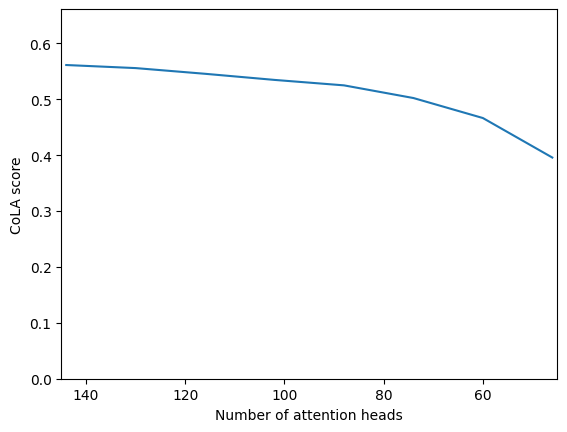

In [10]:
import matplotlib.pyplot as plt

plt.plot(masking_results['heads'], masking_results['scores'])
plt.xlabel("Number of attention heads")
plt.ylabel("CoLA score")
plt.axis([max(masking_results['heads'])+1, min(masking_results['heads'])-1, 0, max(masking_results['scores'])+0.1])

pass

# Additional thoughts

While the technique introduced by Michel et al. certainly has a lot of merits, this particular implementation of it may fail to generalize. Given that we prune heads and score the model using the same dataset split, the model may just "forget" the patterns not present in it.

Secondly, even the important heads may be further improved upon. Combining pruning with another approach, such as distillation, may give even better results.